In [1]:
# for colab insert pip install
# !pip install torch numpy statsmodels matplotlib seaborn tqdm

In [2]:
import torch
import numpy as np
from statsmodels.tsa.stattools import acf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

def plot2d_routine(target, chain, k, bounds, n_points=150, reinit=False):
    points = chain[:,k,:].numpy()
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    target.plot2d_pdf(ax[0], n_points=n_points, bounds=bounds, reinit=reinit)
    ax[0].scatter(points[1:,0], points[1:,1], alpha=0.75, marker='o', s=50)
    ax[1].scatter(range(points.shape[0]), points[:,0])
    ax[2].scatter(range(points.shape[0]), points[:,1])
    
    ax_text = ['Samples', 'Chains states: First coordinate', 'Chains states: Second coordinate']
    for j, i in enumerate(ax.flatten()):
        i.grid(True);
        i.title.set_text(ax_text[j])

# MLSS 2019: MH-MCMC for Probabilistic Numerics

***Table of contents***
0. [Intro](#sampling)
1. [Metropolis-Hastings Markov Chain](#mh)
    - [Problem 0.1](#mh01)
    - [Problem 0.2](#mh02) (auxiliary)
    - [Problem 0.3](#mh03) (auxiliary)
    - [MH-MCMC Algorithm Step](#mhstep)
    
2. [General Classes](#code_base_class): multivariate normal, target, proposal and MH-Sampler, target distributions
    - [Target distributions](#target_pics)
    
3. [Simple Proposals](#proposals):
    - [Independet](#independent)
    - [Random Walk: Problem 1.1](#randomwalk)
    - [Langevin: Problem 1.2](#langevin)
3. [HMC Proposal](#hmc)
    - [Euler and Verlet integration](#eulerandverlet)
    - [Proposal: Problem 2.1](#hmcproposal)
    - [Magic Step Size: Problem 2.2](#hmcmagicstepsize)

<a id="sampling"></a>
# Sampling

The goal of a sampling algorithm is to draw a characteristic samples $x\in\mathcal{X}$ from a target probability distribution $p(x)$.
We consider representation of $p(x)$ as 

$$
p(x) = \frac{1}{Z}\exp(-E(x)),~Z = \int_{\mathcal{X}} \exp(-E(x)) dx,~0<Z<\infty.
$$

We would like to estimate expectations of functions $f:\mathcal{X}\to\mathbb{R}$, with respect to $p(\cdot)$:

$$
\mathbb{E}_{p} f(X) = \int_{\mathcal{X}} f(x) p(x) dx = \dfrac{ \int_{\mathcal{X}} f(x) \exp(-E(x)) dx}{ \int_{\mathcal{X}} \exp(-E(x)) dx}.
$$

For problems of interest, $\mathcal{X}$ is high-dimensional and $p(x)$ is a complicated function. Therefore, analytic or numerical integration is infeasible. 
Hence, we consider the Monte Carlo solution to this problem:

$$
x_1,\dots,x_N \sim p(x) \\
\mathbb{E}_{p} f(X) \approx \dfrac{1}{N}\sum\limits_{n=1}^{N}f(x_n)
$$

The question is how to construct ***effective simulation?*** Along with other approaches (Importance Sampling, Rejection Sampling, Quasi Monte-Carlo, $\dots$)
we consider Markov chain Monte Carlo (MCMC) solution:

1. Construct a discrite time Markov chain on $\mathcal{X}$ which is easily-simulated 
2. Have the unique stationary distribution $p(X)$

Hence, we need to define trasition kernel $K(x, dx')$ between states on $\mathcal{X}\times\mathcal{B}(\mathcal{X})$:

1. $\forall x\in\mathcal{X}, K(\cdot, dx')$ is a pobability density
2. $\forall A\subset\mathcal{X}, K(\cdot, A)$ is a measurable

If the state space $\mathcal{X}$ is discrite, the transtional kernel is a matrix. In the continuous case, we obtain the conditional density:

$$
P(x'\in A|x) = \int_{A}K(x,x')dx'.
$$

As we want the statinary distribution of the chain to be $p(x)$, hence the fixed-point equation should hold:

$$
\int_\mathcal{X} p(dx)P(x, dx') = p(dx').
$$

However, it's hard to construct such transition kernel directly, as the constrained is at the integral form. Instead, following the **Metropolis&Hastings** we consider the pointwise condition that implies stationarity with respect to the $p(x)$.

<a id="mh"></a>
# Constructing MH-MCMC Algorithms

## Reversibility (Detailed Balance)

A Markov chain on a state spaces $\mathcal{X}$ is *reversible* with respect to the the $p(x)$ on $\mathcal{X}$, if

$$p(dx)P(x, dx') = p(dx')P(x', dx)$$

<a id="mh01"></a>
#### Problem 0.1
Show, that if $P(x, dx')$ is reversible with respect to the $p(dx)$, than $p(dx)$ is the stationary distribution of the chain. 

#### Solution 

$$
\int_{x\in\mathcal{X}} p(dx)P(x, dx') = \int_{x\in\mathcal{X}} p(dx')P(x', dx) = p(dx') \int_{x\in\mathcal{X}} P(x', dx) = p(dx')
$$

<a id="mh02"></a>
####  Additional problems for those who are bored 0.2
Consider two different reversible chains $P_1$, $P_2$, each having stationary distribution $p(x)$. 
Show:

1. The combined chain $P_1 P_2$ has the stationary distribution $p(x)$. 
2. The combined chain $P_1 P_2$ is not reversible
3. The combined chain $P_1 P_2 P_2 P_1$ is reversible

## Metropolis-Hastings Algorithm: Proposals and Rejections Markov Transtion

Given the Markov kernel $Q(x, dx')$ as proposal kernel, we want to accept or reject proposals in such way, that whole chain is reversible with respect to the $p(x)$.

$$
P(x, dx') = \underbrace{Q(x, dx')\alpha(x, x')}_{\text{Acceptance: new state transition}} + \underbrace{\left[1- \int_\mathcal{X}\alpha(x, u)Q(x, du)\right]\delta_{x}(dx')}_{\text{Rejection: current state remain}}
$$


We need to specify the function $\alpha(x, x')$ such that reversibility of kernel $P(x, dx')$ holds with respect to the $p(x)$:

$$
p(dx)Q(x, dx')\alpha(x, x') = p(dx')Q(x', dx)\alpha(x', x),
$$

denote $t(x, x') = \dfrac{p(dx)Q(x, x')}{p(dx')Q(x', dx)}$, we obtain:

$$
\alpha(x, x')t(x, x') =  \alpha(x', x).
$$

From that we could derive several statements:

1. Denote $s(x,x') = \alpha(x,x')+\alpha(x'x)$, note that $s(x,x')$ is symmetric function. Then:

$$
\alpha(x, x')t(x, x') =  \alpha(x', x)~|~\text{ add $\alpha(x, x')$ to both parts }, \\
\alpha(x, x')(1+t(x, x')) =  \alpha(x', x) + \alpha(x, x'), \\
\alpha(x, x') = \dfrac{s(x,x')}{1+t(x,x')}.
$$

2. $\alpha(x, x')\leq \min\{1, t(x',x)\}$.

<a id='mh03'></a>
####  Additional problems for those who are bored 0.3
1. Consider $s(x,x') = 1$, i.e. $\alpha(x, x')=\dfrac{1}{1+t(x,x')}$. Check, that $P(x, dx')$ is reversible kernel with respect to the p(x).
2. Consider $\alpha(x,x') = \min\{1, t(x',x)\}$ Check, that $P(x, dx')$ is reversible kernel with respect to the p(x).

<a id='mhstep'></a>
#### MH-MCMC Algorithm Step

We could summirize the iteration of the algorithm MH-MCMC as following:


1. Sample proposal point $x' \sim q(x'|x)$, given previous point $x$
2. Accept: 
$$
\left\{\begin{matrix}
x', &\text{accept with probability}~p & \\ 
x, & \text{otherwise}
\end{matrix}\right.
$$

$$
p = \min\left\{1, \frac{p(x')q(x| x')}{p(x)q(x'| x)}\right\}
$$


Note, that we could simulate the mixture component by comparing $p$ with sample from the uniform distribution $U[0;1]$. In practice, we will work at the $log$ scale.



Note, that here we assume that proposal kernel has the density $Q(x, dx')=q(x'|x)dx'$. However, later we will discuss the deterministic transition 

<a id="mh"></a>
# Code for General Classes

Basic distribution is multivariate gaussian:

In [3]:
class batch_mvn:
    '''
    mu (torch tensor (B,D)): batch of mean
    L (torch tensor (B,D,D)): batch corrsepondend Choltetsky factor, low triangular
    L (torch tensor (B,D)): batch corrsepondend Choltetsky factor, diagonal 
    x (torch tensor (B,D)) batch of points
    '''
    @staticmethod
    def rvs(mu, L, diag=False):
        '''
        Out:
            (torch tensor (B,D)) batch from N(x|mu, LL^T)
        '''
        if diag:
            eps = torch.randn_like(mu)
            sample = mu + eps * L
        else:
            eps = torch.randn_like(mu).unsqueeze(-1)
            sample = mu.unsqueeze(-1) + torch.einsum('ijk,ikl->ijl', [L, eps])
            sample = sample.squeeze(-1)
        return sample
    
    @staticmethod
    def E(x, mu, L, diag=False):
        '''
        Out:
            (torch tensor (B,)) batch of energy N(x|mu, LL^T)
        '''
        if diag:
            vec = (x - mu) / L
        else:
            vec, _ = torch.triangular_solve((x-mu).unsqueeze(2), L, upper=False)
            vec = vec.squeeze(2)
        return 0.5 * torch.sum(vec ** 2, dim=1)
    
    @staticmethod
    def logpdf(x, mu, L, diag=False):
        '''
        Out:
            (torch tensor (B,)) batch of log  N(x|mu, LL^T)
        '''
        e = batch_mvn.E(x, mu, L, diag)
        if diag:
            log_det = torch.sum(torch.log(L))
        else:
            log_det = torch.einsum('ijj', [torch.log(L)])
        return - e - log_det - mu.size(1)*0.5 * torch.log(torch.tensor(2*np.pi))

Class for target distribution representation:

In [4]:
class Target:
    '''
     x (torch tensor (B,D)) batch of points
    '''
    def __init__(self):
        self.cached_grid = None  # plot trivial round
        
    def E(self, x):
        '''
         Out:
             energy E from p = exp(-E(x)) (torch tensor (B,))
        '''
        raise NotImplementedError
        
    def E_ratio(self, x_s, x_p):
        return -(self.E(x_p) - self.E(x_s))
        
    def get_grad_E(self, x):
        '''
         Out:
             grad of E from p = exp(-E(x)) (torch tensor (B,D))
        '''
        x = x.clone().requires_grad_()
        E = self.E(x)
        E.sum().backward()
        return x.grad
    
    
    # plot trivial round #
        
    def plot2d_pdf(self, ax, n_points=50, bounds=[(-6,6), (-6,6)], reinit=False):
        bounds_x = bounds[0]
        bounds_y = bounds[1]
        
        x = np.linspace(*bounds_x, n_points)
        y = np.linspace(*bounds_y, n_points)
        levels = np.zeros((len(x),len(y)))
        if reinit is None:
            levels = self.cached_grid
        else:
            for i in range(len(x)):
                for j in range(len(y)):
                    levels[i,j]= np.exp(-self.E(torch.tensor([x[i], y[j]]).unsqueeze(0)).numpy())
            self.cached_grid = levels
        levels /= np.sum(levels)
        ax.contour(x,y,levels.T)
        ax.title.set_text(self.name)

Class for proposal representation:

In [5]:
class Proposal:
    '''
     x_s, x_p (torch tensor (B,D)) batch of points
    '''
    def transition(self, x_s):
        '''
        Out:
            x_p (torch tensor (B,D)) batch of proposal points x_p
        '''
        raise NotImplementedError
    
    def E(self, x_s, x_p):
        raise NotImplementedError
        
    def E_ratio(self, x_s, x_p):
        return -(self.E(x_s, x_p) - self.E(x_p, x_s)) 

Class for MH sampler:

In [6]:
class MHSampler:
    def __init__(self, proposal, target, verbose=True):
        self.q = proposal
        self.p = target
        self.chain = None
        self.chain_stat = None
                    
    def log_acceptance_prob(self, x_s, x_p):
        log_p_ratio = self.p.E_ratio(x_s, x_p)
        log_q_ratio = self.q.E_ratio(x_s, x_p)
        return log_p_ratio + log_q_ratio
          
    def make_transtion(self, x_s):
        x_p = self.q.transition(x_s)
        stat = self.log_acceptance_prob(x_s, x_p)
        log_u = torch.log(torch.rand(x_p.size(0)))
        flag = stat > log_u
        return x_p, flag
    
    def sample_chain(self, init, N):       
        self.chain_stat = {
            'AR': torch.zeros((init.size(0), N)),
            'ESS': None
        }
        
        chain = torch.zeros((N+1, *init.size()))
        chain[0] = init
        for i in tqdm(range(N)):
            x_p, flag = self.make_transtion(chain[i])
            chain[i+1] = chain[i]
            chain[i+1][flag] = x_p[flag]
            
            self.chain_stat['AR'][:,i] = flag
        self.chain = chain if (self.chain is None) else torch.stack([self.chain, chain], dim=0)
        self.chain_stat['ESS'] = [MHSampler.compute_ess(self.chain[:,i,:].numpy()) for i in range(init.size(0))]
        
        print('AR: %.2f, ESS: %.2f' % (torch.mean(self.chain_stat['AR']), np.mean(self.chain_stat['ESS'])))
        
        return (torch.mean(self.chain_stat['AR']), np.mean(self.chain_stat['ESS']))
    
    # ESS trivial round #
    
    @staticmethod
    def find_first(X):
        for i in range(X.shape[0]):
            if X[i]:
                return i
        return -1
    
    @staticmethod
    def integrated_autocorr(x, acf_cutoff=0.0):
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        n = len(x)
        tau = np.zeros(x.shape[1])
        for j in range(x.shape[1]):
            f = acf(x[:,j], nlags=n, unbiased=False, fft=True)
            window = MHSampler.find_first((f <= acf_cutoff).astype(np.uint8))
            tau[j] = 1 + 2*f[1:window].sum()

        return tau
    
    @staticmethod
    def compute_ess(x, acf_cutoff=0.0):
        tau = MHSampler.integrated_autocorr(x, acf_cutoff=acf_cutoff)
        return np.min(x.shape[0] / tau)

In [7]:
class PickleRick(Target):
    def __init__(self, mu, L, diag=False):
        self.name = 'Pickle Rick'
        self.diag = diag
        self.L = L
        self.mu = mu
        
    def E(self, x):
        return batch_mvn.E(x, self.mu, self.L, self.diag)

    
class Banana(Target):
    def __init__(self, mu, L, diag=False):
        self.name = 'Banana'
        self.diag = diag
        self.L = L
        self.mu = mu
    
    def E(self, x):
        y = -x.clone()
        y[:,1] = x[:,1] + 0.5 * x[:,0] ** 2 + 1
        return batch_mvn.E(y, self.mu, self.L, self.diag)

    
class ThreeMixture(Target):
    def __init__(self, mu, L, diag=False):
        self.name = 'Three Mixture'
        self.K = mu.size(0)
        self.diag = diag
        self.L = L
        self.mu = mu
        
    def E(self, x):
        vec = torch.zeros((x.size(0), self.K))
        for k in range(self.K):
            vec[:,k] = -batch_mvn.E(x, self.mu[k].unsqueeze(0), self.L[k].unsqueeze(0))
        return -torch.logsumexp(vec, dim=1)

<a id="target_pics"></a>
### Target distributions

In [8]:
L_target = torch.cholesky(torch.tensor([[1., 0.95], [0.95, 1.]]))
target_pickle = PickleRick(torch.tensor([0.,0.]).unsqueeze(0), L_target)
bound_pickle = [(-2.5, 2), (-2,2)]

L_target = torch.cholesky(torch.tensor([[1., 0.95], [0.95, 1.]]))
target_banana = Banana(torch.tensor([0.,0.]).unsqueeze(0), L_target.unsqueeze(0))
bound_banana = [(-2,2), (-5,1)]

mu = torch.tensor([0,-1,0,3,3,3], dtype=torch.float).reshape(3,2)
L = torch.cholesky(torch.tensor([[1., 0.85], [0.85, 1.]]))
L_ = torch.cholesky(torch.tensor([[1., -0.85], [-0.85, 1.]]))
L_vec = torch.stack([L_, L, L_])
target_three = ThreeMixture(mu, L_vec)
bound_three = [(-3, 6), (-3,6)]

targets = [target_pickle, target_banana, target_three]
bounds = [bound_pickle, bound_banana, bound_three]

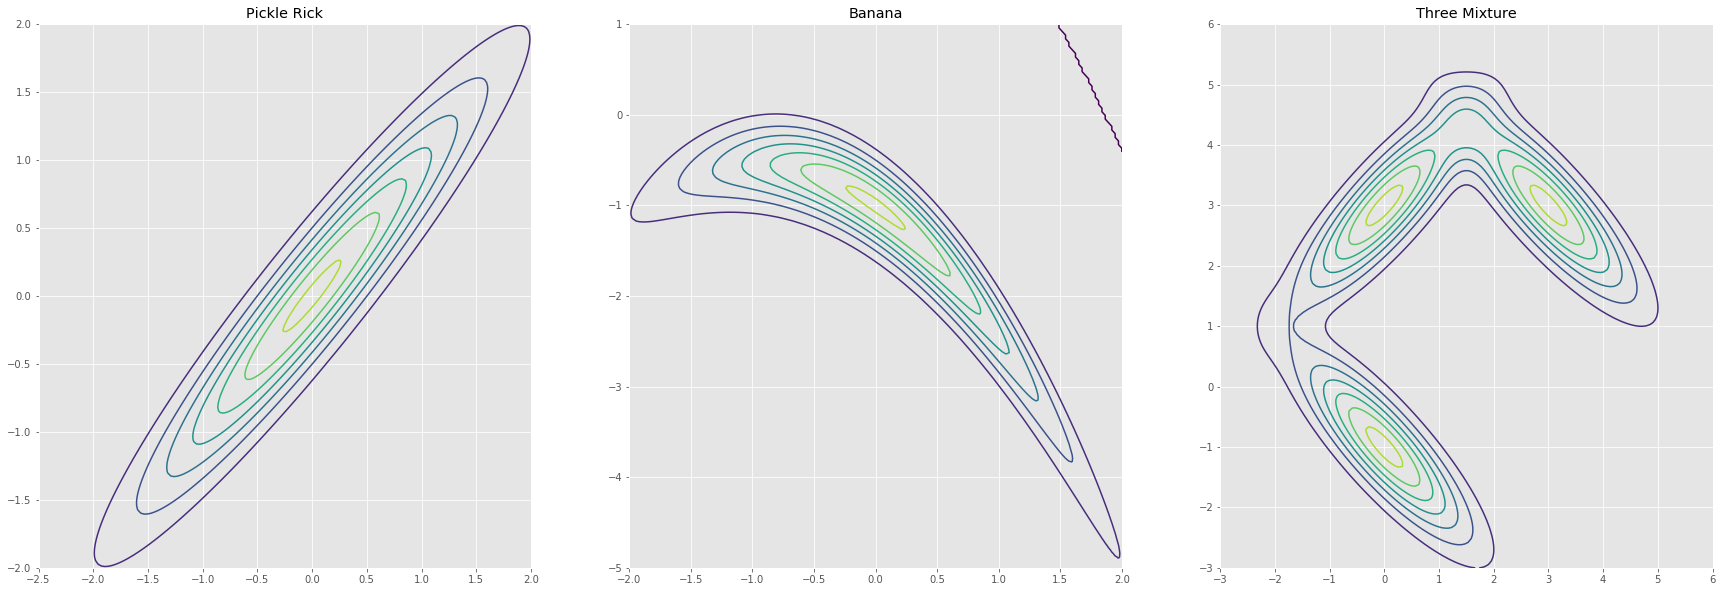

In [9]:
fig, ax = plt.subplots(1,3, figsize=(30, 10))
for i in range(len(targets)):
    targets[i].plot2d_pdf(ax[i], n_points=150, bounds=bounds[i])

<a id='proposals'></a>
## Simple Proposals

### Independent 
<a id='independent'></a>
$$
q(x_s|x_p) = \mathcal{N}(x_s|\mu, LL^T)
$$

In [10]:
class Independent(Proposal):
    def __init__(self, mu, L, diag=False):
        self.diag = diag
        self.L = L
        self.mu = mu
        
    def transition(self, x_s):
        return batch_mvn.rvs(self.mu, self.L, self.diag)
    
    def E(self, x_s, x_p):
        return batch_mvn.E(x_p, self.mu, self.L, self.diag)

100%|██████████| 100/100 [00:00<00:00, 1775.59it/s]


AR: 0.21, ESS: 18.40


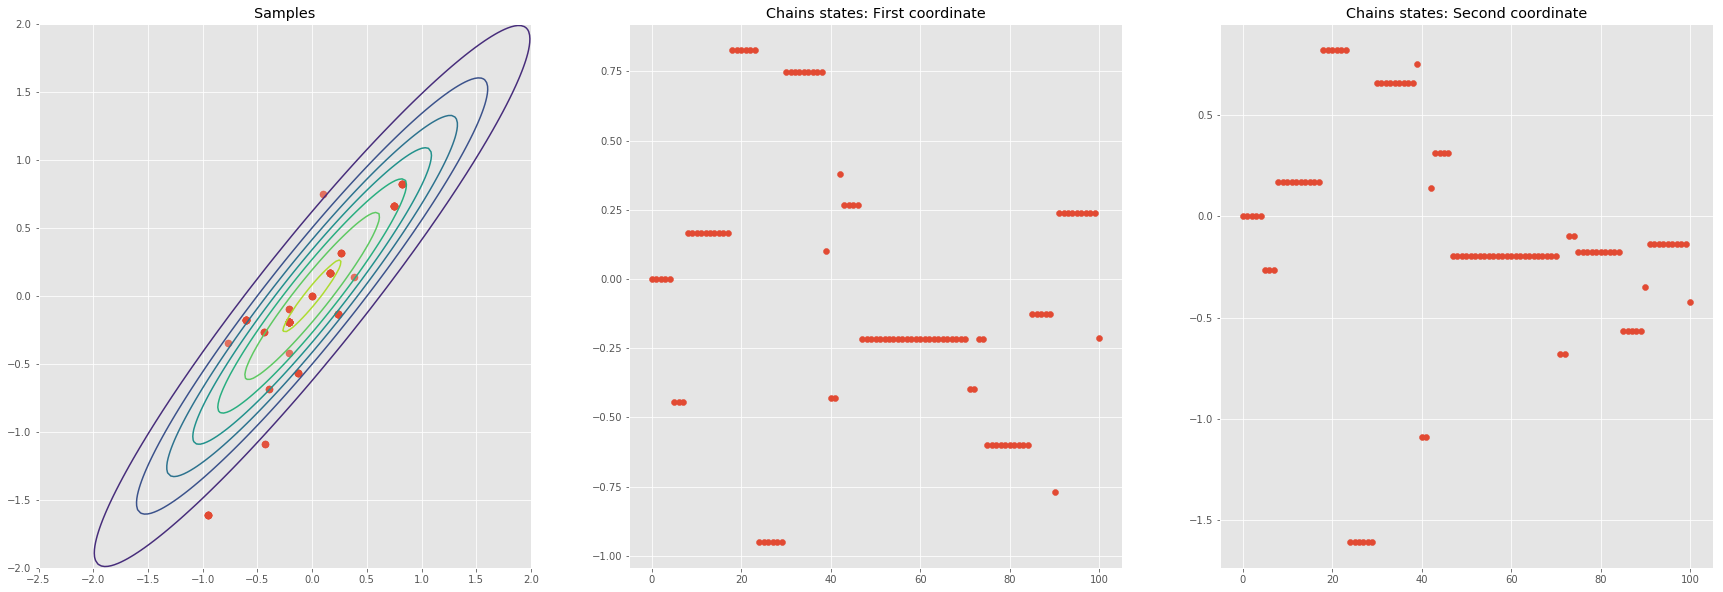

In [11]:
k = 100
L_iid = torch.ones(1,2)
mu_iid = torch.zeros(k,2)
iid_proposal = Independent(mu_iid, L_iid, diag=True)
iid_pickle_sampler = MHSampler(iid_proposal, targets[0])

init = torch.zeros(k,2)
iid_pickle_sampler.sample_chain(init, 100)
plot2d_routine(targets[0], iid_pickle_sampler.chain, 0, bounds[0])

In [12]:
k = 100
L_iid = 0.24*torch.ones(1,2)
mu_iid = torch.zeros(k,2)
iid_proposal = Independent(mu_iid, L_iid, diag=True)
iid_pickle_sampler = MHSampler(iid_proposal, targets[0])

init = torch.zeros(k,2)
iid_pickle_sampler.sample_chain(init, 100)

100%|██████████| 100/100 [00:00<00:00, 1639.80it/s]

AR: 0.56, ESS: 43.89


(tensor(0.5610), 43.888278682128565)

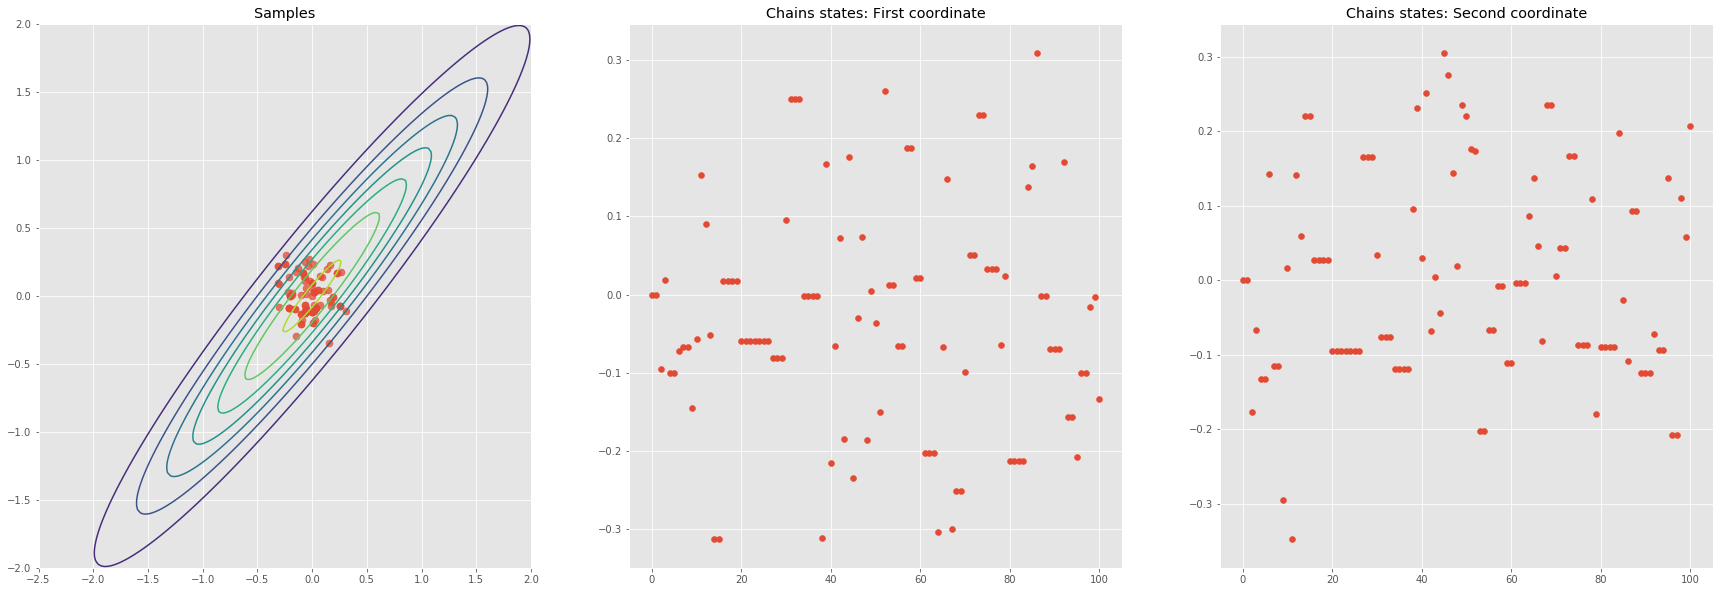

In [13]:
plot2d_routine(targets[0], iid_pickle_sampler.chain, 0, bounds[0])

100%|██████████| 100/100 [00:00<00:00, 1993.54it/s]


AR: 0.57, ESS: 52.42


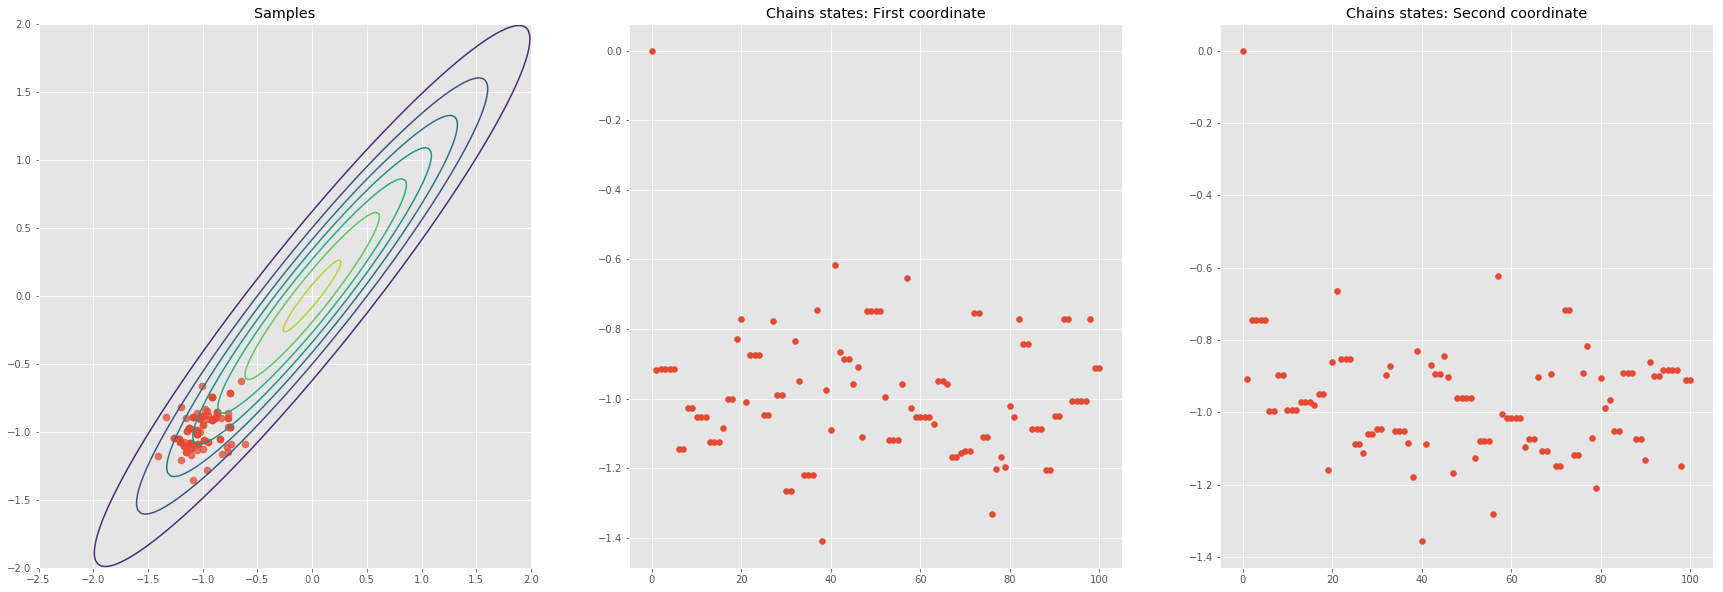

In [14]:
k = 100
L_iid = 0.24*torch.ones(1,2)
mu_iid = torch.zeros(k,2) - 1
iid_proposal = Independent(mu_iid, L_iid, diag=True)
iid_pickle_sampler = MHSampler(iid_proposal, targets[0])
init = torch.zeros(k,2)
init = torch.zeros(k,2)
iid_pickle_sampler.sample_chain(init, 100)
plot2d_routine(targets[0], iid_pickle_sampler.chain, 0, bounds[0])

100%|██████████| 100/100 [00:00<00:00, 2098.01it/s]


AR: 0.08, ESS: 8.96


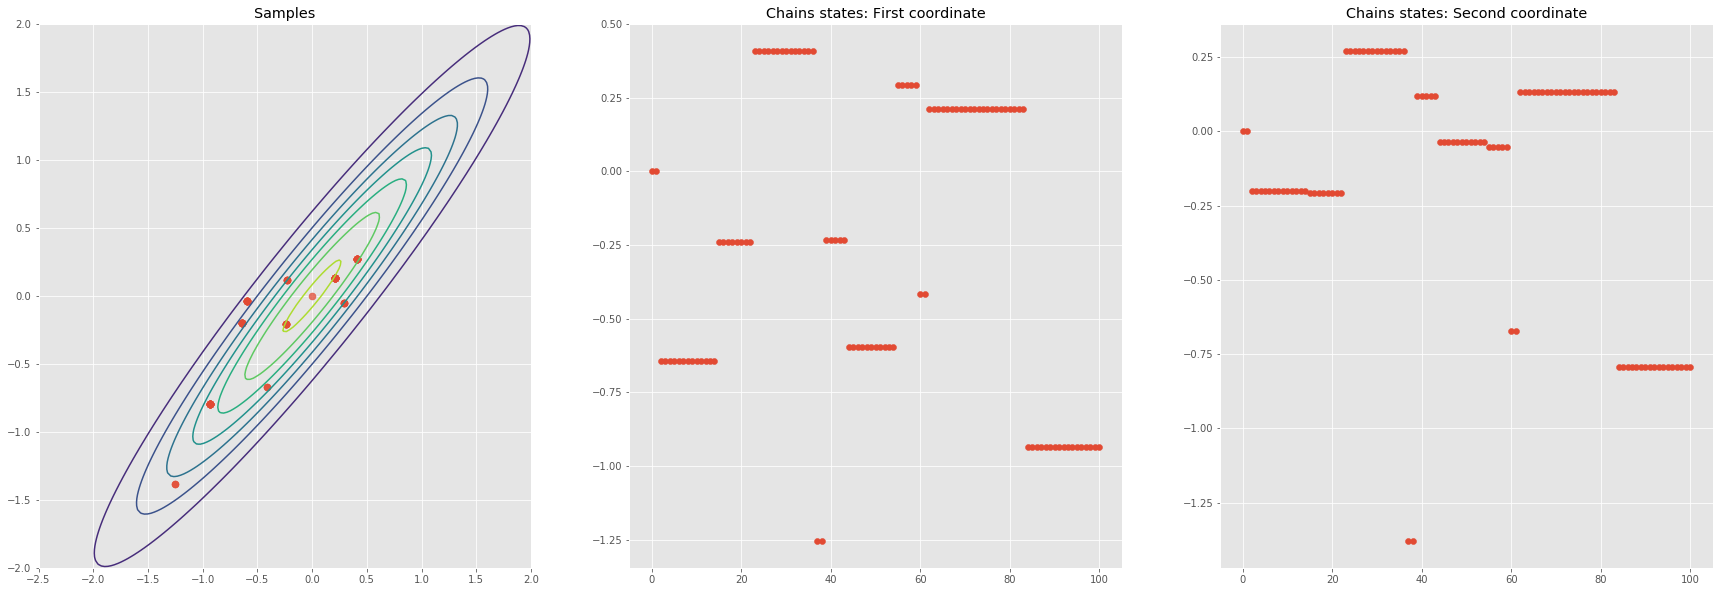

In [16]:
k = 200
L_iid = 2*torch.ones(1,2)
mu_iid = torch.zeros(k,2) - 1
iid_proposal = Independent(mu_iid, L_iid, diag=True)
iid_pickle_sampler = MHSampler(iid_proposal, targets[0])
init = torch.zeros(k,2)
init = torch.zeros(k,2)
iid_pickle_sampler.sample_chain(init, 100)
plot2d_routine(targets[0], iid_pickle_sampler.chain, 0, bounds[0])

### Random Walk 
<a id='randomwalk'></a>

$$
q(x_s|x_p) = \mathcal{N}(x_s|x_p, LL^T)
$$

In [17]:
class RandomWalk(Proposal):
    def __init__(self, L, diag=False):
        self.L = L
        self.diag = diag
        
    def transition(self, x_s):
        # your code here
        pass
        
    def E(self, x_s, x_p):
        # your code here
        pass

100%|██████████| 100/100 [00:00<00:00, 1250.12it/s]


AR: 0.67, ESS: 5.71


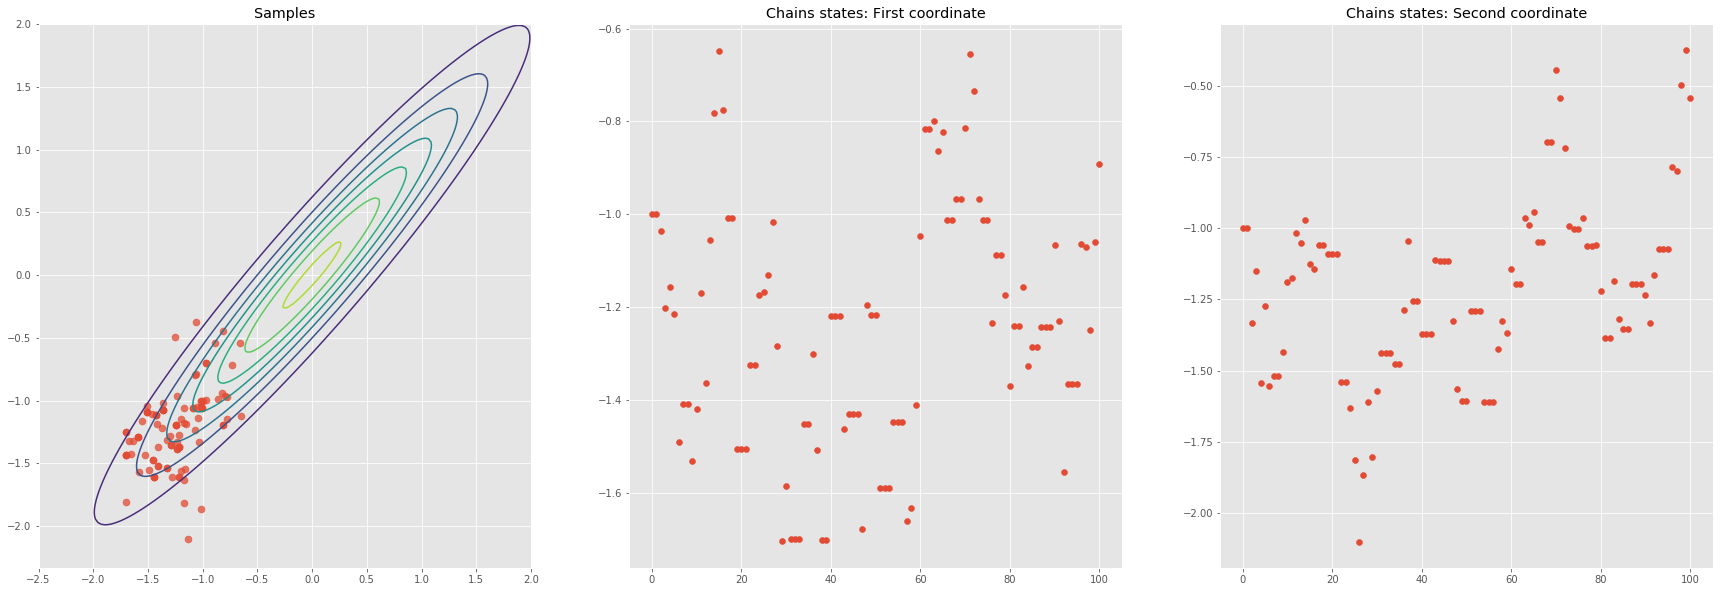

In [18]:
k = 200
L_rw = 0.24*torch.ones(1,2)
rw_proposal = RandomWalk(L_rw, diag=True)
rw_pickle_sampler = MHSampler(rw_proposal, targets[0])

init = torch.zeros(k,2) - 1
rw_pickle_sampler.sample_chain(init, 100)
plot2d_routine(targets[0], rw_pickle_sampler.chain, 0, bounds[0])

100%|██████████| 100/100 [00:00<00:00, 842.74it/s]


AR: 0.55, ESS: 14.64


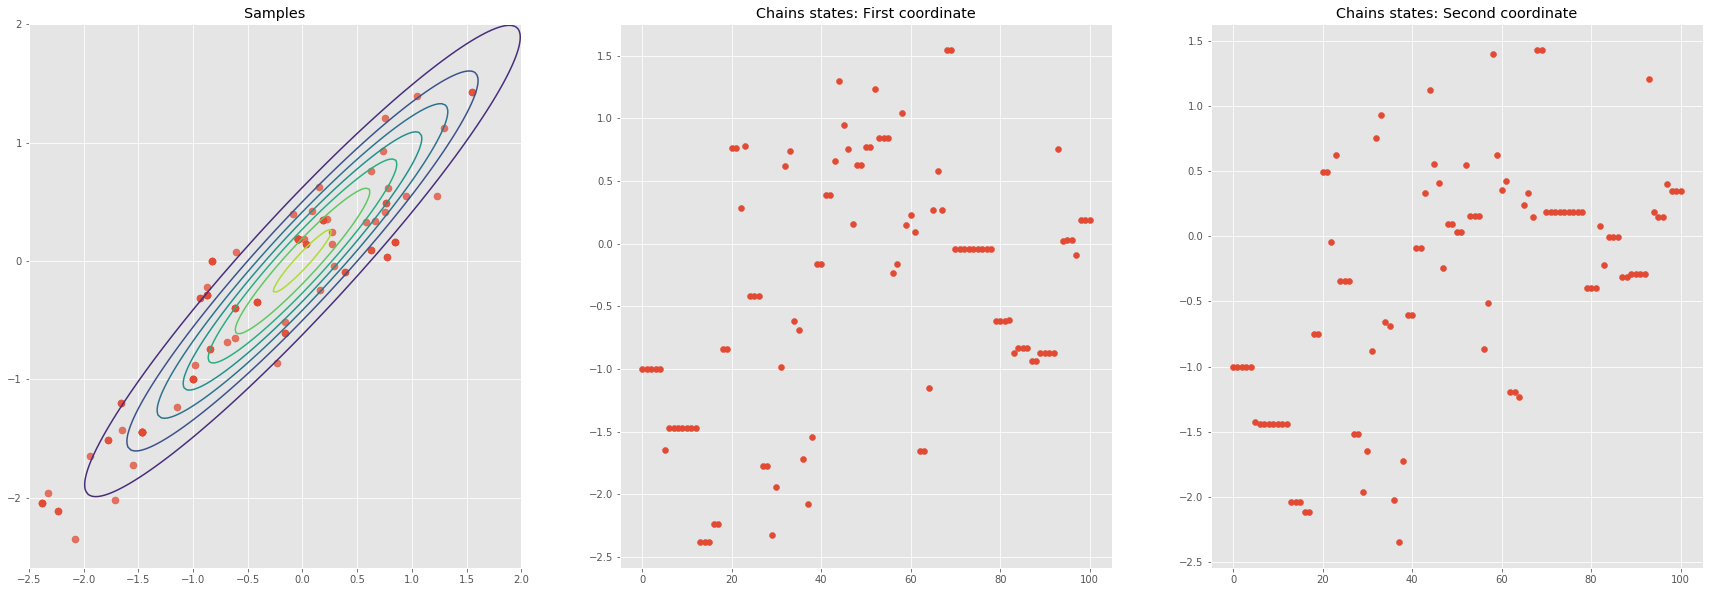

In [20]:
k = 200
L_rw = torch.cholesky(torch.tensor([[1., 0.95], [0.95, 1.]]))
rw_proposal = RandomWalk(L_rw.expand(k,2,2), diag=False)
rw_pickle_sampler = MHSampler(rw_proposal, targets[0])

init = torch.zeros(k,2) - 1
rw_pickle_sampler.sample_chain(init, 100)
plot2d_routine(targets[0], rw_pickle_sampler.chain, 0, bounds[0])

### Langevin Dynamics
<a id='langevin'></a>

$$
q(x_s|x_p) = \mathcal{N}(x_p|x_s - \tfrac{\varepsilon}{2}\nabla E(x_s), LL^T)
$$

In [21]:
class Langevin(Proposal):
    def __init__(self, eps, target, L, diag=True):
        self.eps = eps
        self.L = L
        self.target = target
        self.diag = diag
        
    def transition(self, x_s):
        grad = # your code here
        mu = # your code here
        return  # your code here
    
    def E(self, x_s, x_p):
        return # your code here

100%|██████████| 100/100 [00:00<00:00, 703.58it/s]


AR: 0.48, ESS: 8.39


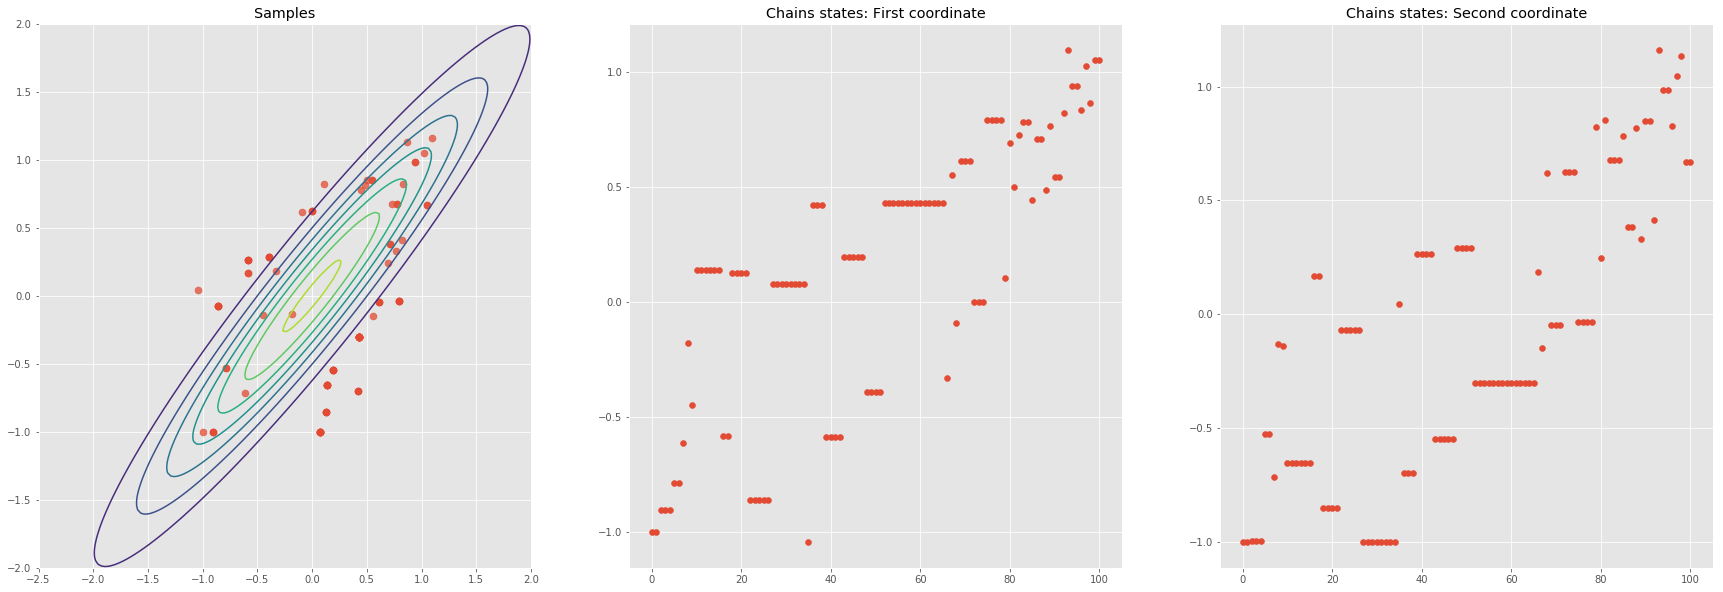

In [22]:
k = 200
eps = 0.24
L_rw = torch.ones(1,2)
french_proposal = Langevin(eps, targets[0], L_rw, diag=True)
french_pickle_sampler = MHSampler(french_proposal, targets[0])

init = torch.zeros(k,2) - 1
french_pickle_sampler.sample_chain(init, 100)
plot2d_routine(targets[0], french_pickle_sampler.chain, 0, bounds[0])

100%|██████████| 100/100 [00:00<00:00, 805.51it/s]


AR: 0.87, ESS: 5.97


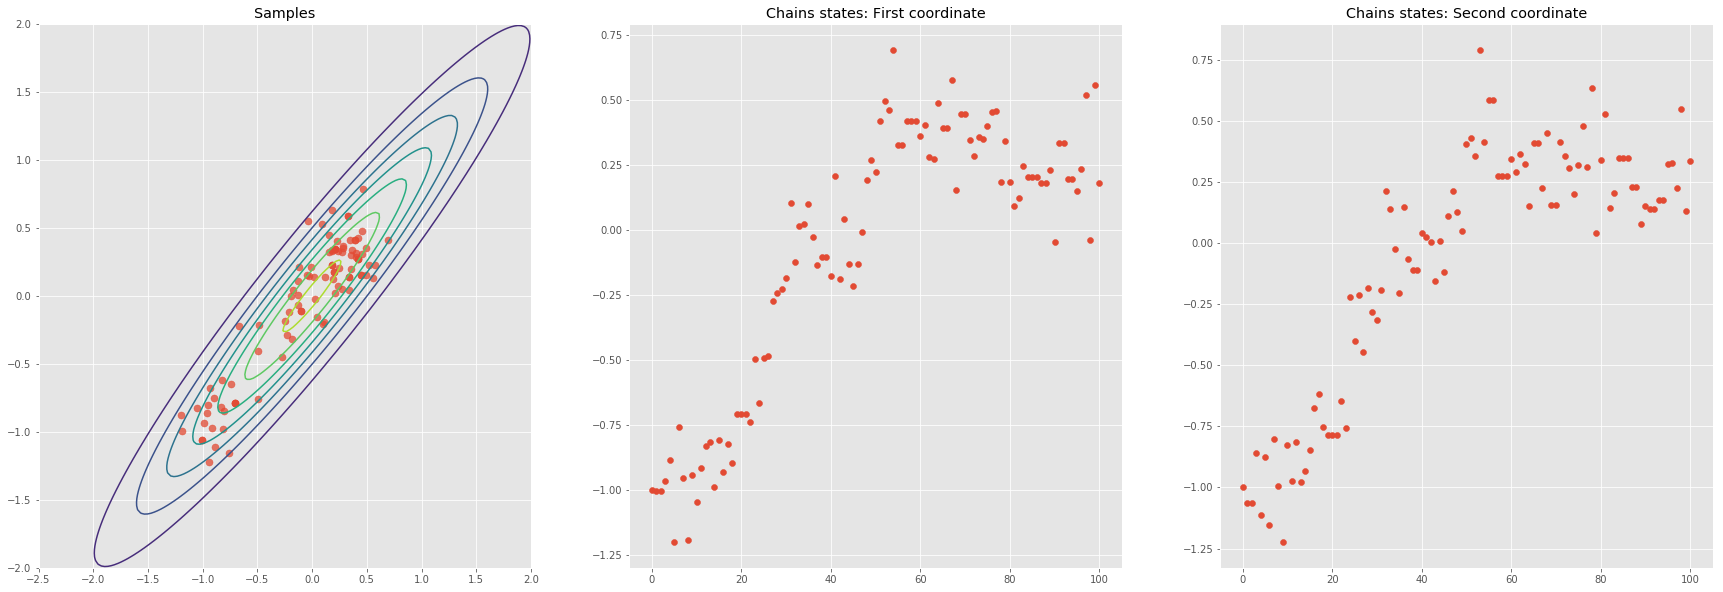

In [23]:
k = 200
eps = 0.15
L_rw = torch.ones(1,2)
french_proposal = Langevin(eps, targets[0], L_rw, diag=True)
french_pickle_sampler = MHSampler(french_proposal, targets[0])

init = torch.zeros(k,2) - 1
french_pickle_sampler.sample_chain(init, 100)
plot2d_routine(targets[0], french_pickle_sampler.chain, 0, bounds[0])

100%|██████████| 100/100 [00:00<00:00, 407.96it/s]


AR: 0.71, ESS: 66.60


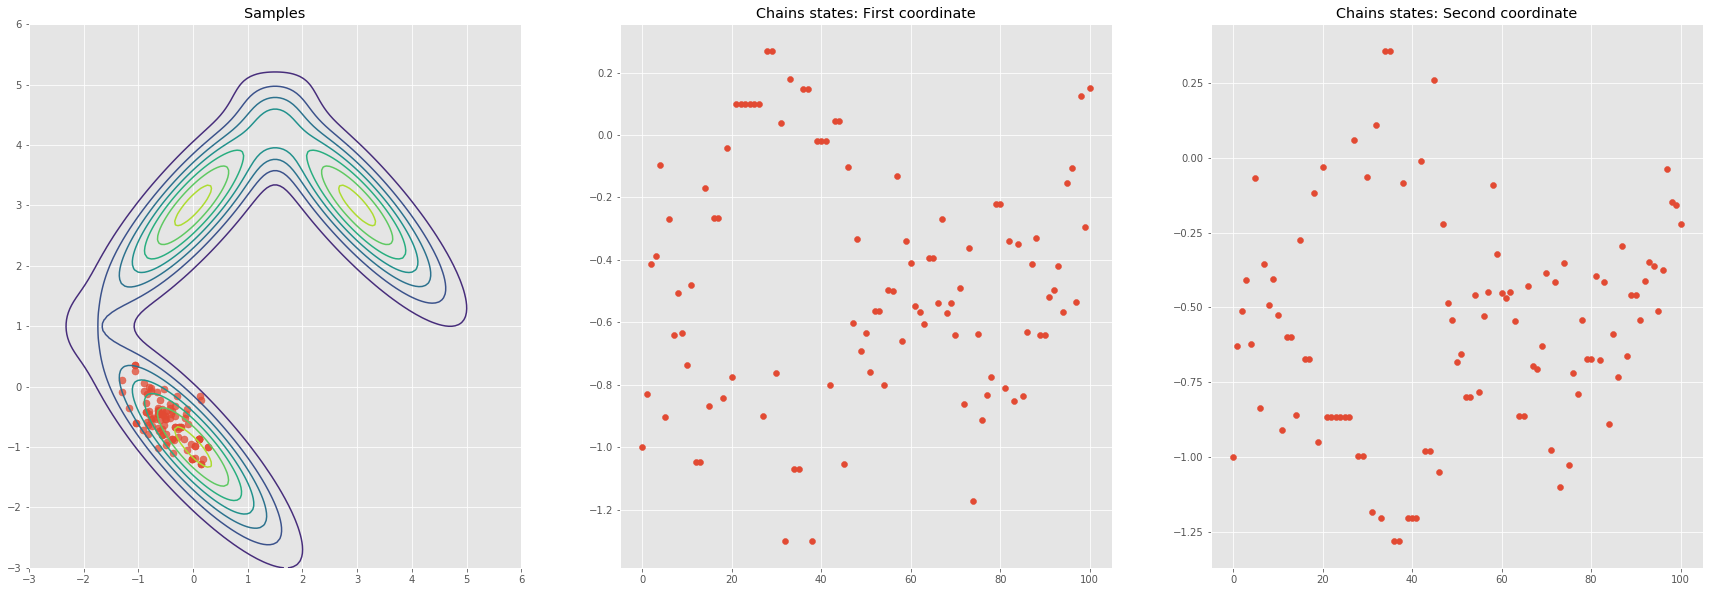

In [24]:
k = 200
eps = 0.2
L_rw = torch.ones(1,2)
french_proposal = Langevin(eps, targets[0], L_rw, diag=True)
french_pickle_sampler = MHSampler(french_proposal, targets[-1])

init = torch.zeros(k,2) - 1
french_pickle_sampler.sample_chain(init, 100)
plot2d_routine(targets[-1], french_pickle_sampler.chain, -1, bounds[-1])

<a id='hmc'></a>
## HMC Proposal

1. Consider the target density $p(x)$ as marginal of the distriubtion: 


$$
p(x, p) = p(x)p(p|x) \propto \exp(-H(x,p)).
$$

2. Consider $p(p|x)$ as $$\mathcal{N}(p|0; G(x))$$.


3. We would like to conserve the $p(x,p)$ and accept every proposal. Hece we would like to simulate the hamiltonian dynamics with:

$$
H(x, p) = -\mathcal{L}(x) + \tfrac{1}{2}\log|2\pi G(x)| + \tfrac{1}{2}p^TG(x)^{-1}p,
$$

And dynamics 

$$
\left\{\begin{matrix}
& \dot{x} = \tfrac{\partial}{\partial p}H  =  G(x)^{-1}p  \\ 
& \dot{p} = - \tfrac{\partial}{\partial x}H =\tfrac{\partial}{\partial x}\mathcal{L}  -\tfrac{1}{2}\text{Tr}\left(G(x)^{-1}\tfrac{\partial}{\partial x}G(x) \right ) + \tfrac{1}{2}p^TG(x)^{-1}\tfrac{\partial}{\partial x}G(x) G(x)^{-1}p
\end{matrix}\right.
$$

Pros:

- We taking into account the geometry of the distribution by the $G(x)$

Cons:

- Hamiltonian is not separable -> numeric integration scheme will be implicit

Hence, let's start by simple HMC with 

$$p(p|x) = p(p) = \mathcal{N}(p|0,I)$$, the dynamics:

And dynamics 

$$
\left\{\begin{matrix}
& \dot{x} = \tfrac{\partial}{\partial p}H  = p  \\ 
& \dot{p} = - \tfrac{\partial}{\partial x}H = \nabla_{x}\mathcal{L}(x)
\end{matrix}\right.
$$


Yet we need to perform numeric integration of the dynamics. Hence, we need also to perform acceptance test $\xi = [x, p]$:

$$
\alpha(\xi_p, \xi_s) = \min\left(1, \dfrac{\exp(-H(x_p, p_p))}{\exp(-H(x_s, p_s))} \right). 
$$


<a id='eulerandverlet'></a>
### Euler and Verlet integration


Consider the one-dimenstional example:

$$
H(q,p) = \tfrac{q^2}{2} + \tfrac{p^2}{2}.
$$

The dynamics inducing by this Hamiltonian 

$$
\dot{q} = p \\
\dot{p} = -q,
$$

To follow hamiltonian flow, we need to perform numeric integration.
We will consider to possible choices: 

In [25]:
def euler_step(z0, grad0, eps):
    '''
    z0 := (q, p) at the current moment
    grad0 := (\dot{q}, \dot{p}) at z0
    eps := size of the step
    '''
    return z0 + eps * grad0

def leapfrog_step(z0, grad0, eps):
    '''
    z0 := (q, p) at the current moment
    grad0 := (\dot{q}, \dot{p}) at z0
    eps := size of the step
    '''
    z0[1] -=  eps * 0.5 * z0[0]
    z0[0] += eps * z0[1]
    z0[1] -= eps * 0.5 * z0[0]
    return z0

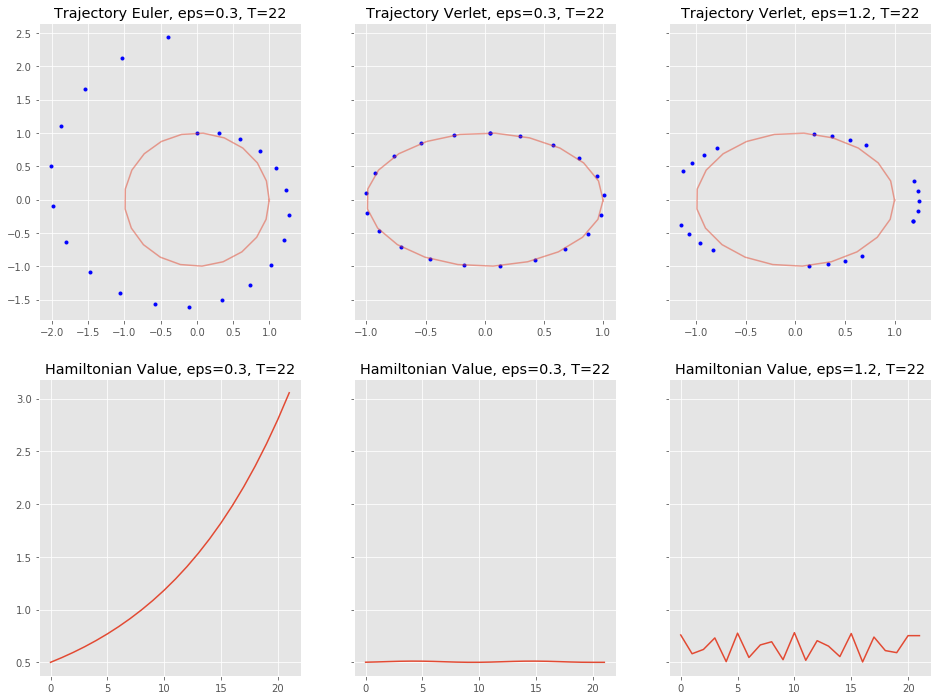

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12), sharex=False, sharey='row')

T = 22
eps = 0.3
z = np.zeros((T, 2))
q_t = [np.cos(t * eps) for t in range(T)]
p_t = [-np.sin(t * eps) for t in range(T)]
z[0] = [0, 1]
grad_matrix = np.array([[0, 1], [-1, 0]])
for n, i in enumerate(z[1:]):
    z[n+1] = euler_step(z[n], grad_matrix @ z[n], eps)

ax[0,0].plot(z[:,0], z[:,1], 'b.');
ax[0,0].plot(q_t, p_t, alpha=0.5);
ax[1,0].plot(np.sum(z ** 2 /2, axis=1));

ax[0,0].title.set_text('Trajectory Euler, eps=0.3, T=22')
ax[1,0].title.set_text('Hamiltonian Value, eps=0.3, T=22')


eps = 0.3
z = np.zeros((T, 2))
z[0] = [0, 1]

grad_matrix = np.array([[0, 1], [-1, 0]])

for n, i in enumerate(z[1:]):
    z[n+1] = leapfrog_step(z[n], grad_matrix @ z[n], eps)

ax[0,1].plot(z[:,0], z[:,1], 'b.');
ax[0,1].grid(True)
ax[0,1].plot(q_t, p_t,  alpha=0.5);
ax[1,1].plot(np.sum(z ** 2 /2, axis=1));

ax[0,1].title.set_text('Trajectory Verlet, eps=0.3, T=22')
ax[1,1].title.set_text('Hamiltonian Value, eps=0.3, T=22')

eps = 1.2
z = np.zeros((T, 2))
z[0] = [0, 1]

grad_matrix = np.array([[0, 1], [-1, 0]])

for n, i in enumerate(z[1:]):
    z[n+1] = leapfrog_step(z[n], grad_matrix @ z[n], eps)

ax[0,2].plot(z[:,0], z[:,1], 'b.');
ax[0,2].grid(True)
ax[0,2].plot(q_t, p_t, alpha=0.5);
ax[1,2].plot(np.sum(z ** 2 /2, axis=1));

ax[0,2].title.set_text('Trajectory Verlet, eps=1.2, T=22')
ax[1,2].title.set_text('Hamiltonian Value, eps=1.2, T=22')


for a in ax.flatten():
    a.grid(True);

Hence, our choice is leapfrog as it is
- volume preserving
- reversible 

With higher-order simpletic integration methods we could achive less error. However, it becomes more costly.

<a id='hmcproposal'></a>
### HMC Proposal Gaussian Kinetic

 1. Fill 'your code here' and obtain HMC proposal
 2. Also you can uniformly randomise number of integration steps $L$

In [27]:
class HMCGaussKinetic(Proposal):
    def __init__(self, eps, target, L, diag=True, verbose=None):
        self.eps = eps
        self.L = L
        self.target = target
        self.diag = diag
        self.aux_state = {'inital': None, 'proposal': None}
        self.verbose = verbose
        if verbose is None:
            self.trace_trajectory = None 
        else:
            self.trace_trajectory = {
                'x': torch.zeros((L+1, *verbose)),
                'p': torch.zeros((L+1, *verbose)),
                'h_xp': torch.zeros((L+1, verbose[0]))
            }
                
    def transition(self, x_s):
        p_s = torch.randn_like(x_s)
        self.aux_state['initial'] = p_s.clone()
        
        x_p = x_s.clone()
        p_p = p_s.clone()
        
        if self.verbose:
            self.trace_trajectory['x'][0] = x_p
            self.trace_trajectory['p'][0] = p_p
            self.trace_trajectory['h_xp'][0] = self.H_xp(x_p, p_p)
            
        p_p -= (0.5 * self.eps) * self.target.get_grad_E(x_p)
        for i in range(self.L):
            # your code here
            
                
        p_p += (0.5 * self.eps) * self.target.get_grad_E(x_p)
        
        if self.verbose:
            self.trace_trajectory['p'][self.L] = p_p

        self.aux_state['proposal'] = p_p.clone()
        return x_p
    
    def E(self, x_s, x_p):
        raise NotImplementedError
        
    def H_xp(self, x, p):
        # your code here
        pass
        
        
    def E_ratio(self, x_s, x_p):
        p_s = self.aux_state['initial']
        p_p = self.aux_state['proposal']
        return 0.5 * (-torch.sum(p_p ** 2, dim=1) + torch.sum(p_s ** 2, dim=1))
    
    def plot2d_trace_trajectory(self, k, bounds, reinit):
        points = self.trace_trajectory['x'][:,k,:].numpy()
        momentum = self.trace_trajectory['p'][:,k,:].numpy()
        h = self.trace_trajectory['h_xp'][:,k].numpy()
        
        bm_points = torch.mean(self.trace_trajectory['x'], dim=1).numpy()
        bm_momentum = torch.mean(self.trace_trajectory['p'], dim=1).numpy()
        bm_h = torch.mean(self.trace_trajectory['h_xp'], dim=1).numpy()
        
        
        if points is None:
            raise ExceptionText('No run with verbose')
        else:
            fig, ax = plt.subplots(2,3, figsize=(30,10))
            self.target.plot2d_pdf(ax[0,0], bounds=bounds, reinit=reinit)
            ax[0,0].plot(points[:,0], points[:,1], '--bo')
            ax[0,0].plot(points[0,0], points[0,1], 'o', label='Start point', color='green')
            ax[0,0].plot(points[-1,0], points[-1,1], 'o', label='End point', color='red')
            ax[0,0].legend()
            ax[0,1].plot(momentum[:,0], momentum[:,1], '--bo')
            ax[0,1].plot(momentum[0,0], momentum[0,1], 'o', label='Start point', color='green')
            ax[0,1].plot(momentum[-1,0],momentum[-1,1], 'o', label='End point', color='red')
            ax[0,1].legend()
            ax[0,2].plot(h, '--bo')
            
            self.target.plot2d_pdf(ax[1,0], bounds=bounds, reinit=reinit)
            ax[1,0].plot(bm_points[:,0], bm_points[:,1], '--bo', alpha=0.5)
            ax[1,0].plot(bm_points[0,0], bm_points[0,1], 'o', label='Start point', color='green', alpha=0.5)
            ax[1,0].plot(bm_points[-1,0], bm_points[-1,1], 'o', label='End point', color='red', alpha=0.5)
            ax[1,0].legend()
            ax[1,1].plot(bm_momentum[:,0], bm_momentum[:,1], '--bo', alpha=0.5)
            ax[1,1].plot(bm_momentum[0,0], bm_momentum[0,1], 'o', label='Start point', color='green', alpha=0.5)
            ax[1,1].plot(bm_momentum[-1,0],bm_momentum[-1,1], 'o', label='End point', color='red', alpha=0.5)
            ax[1,1].legend()
            ax[1,2].plot(bm_h, '--bo')
            
            
            points = self.trace_trajectory['x'].numpy()
            momentum = self.trace_trajectory['p'].numpy()
            h = self.trace_trajectory['h_xp'].numpy()
            
            self.target.plot2d_pdf(ax[1,0], bounds=bounds, reinit=reinit)
            k = points.shape[1]
            alpha = 0.5 * k / (k+2)
            for i in range(points.shape[1]):
                ax[1,0].plot(points[:,i,0], points[:,i,1], '--bo', alpha=alpha)
                ax[1,1].plot(momentum[:,i,0], momentum[:,i,1], '--bo', alpha=alpha)
                ax[1,1].plot(momentum[0,i,0], momentum[0,i,1], 'o', label='Start point', color='green', alpha=alpha)
                ax[1,1].plot(momentum[-1,i,0],momentum[-1,i,1], 'o', label='End point', color='red', alpha=alpha)
                ax[1,2].plot(h[:,i], '--bo', alpha=alpha)
                
            for i in range(points.shape[1]):
                ax[1,0].plot(points[0,i,0], points[0,i,1], 'o', label='Start point', color='green')
                ax[1,0].plot(points[-1,i,0], points[-1,i,1], 'o', label='End point', color='red')
                ax[1,1].plot(momentum[0,i,0], momentum[0,i,1], 'o', label='Start point', color='green')
                ax[1,1].plot(momentum[-1,i,0],momentum[-1,i,1], 'o', label='End point', color='red')

Let's make run and test

100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


AR: 0.96, ESS: 14.16


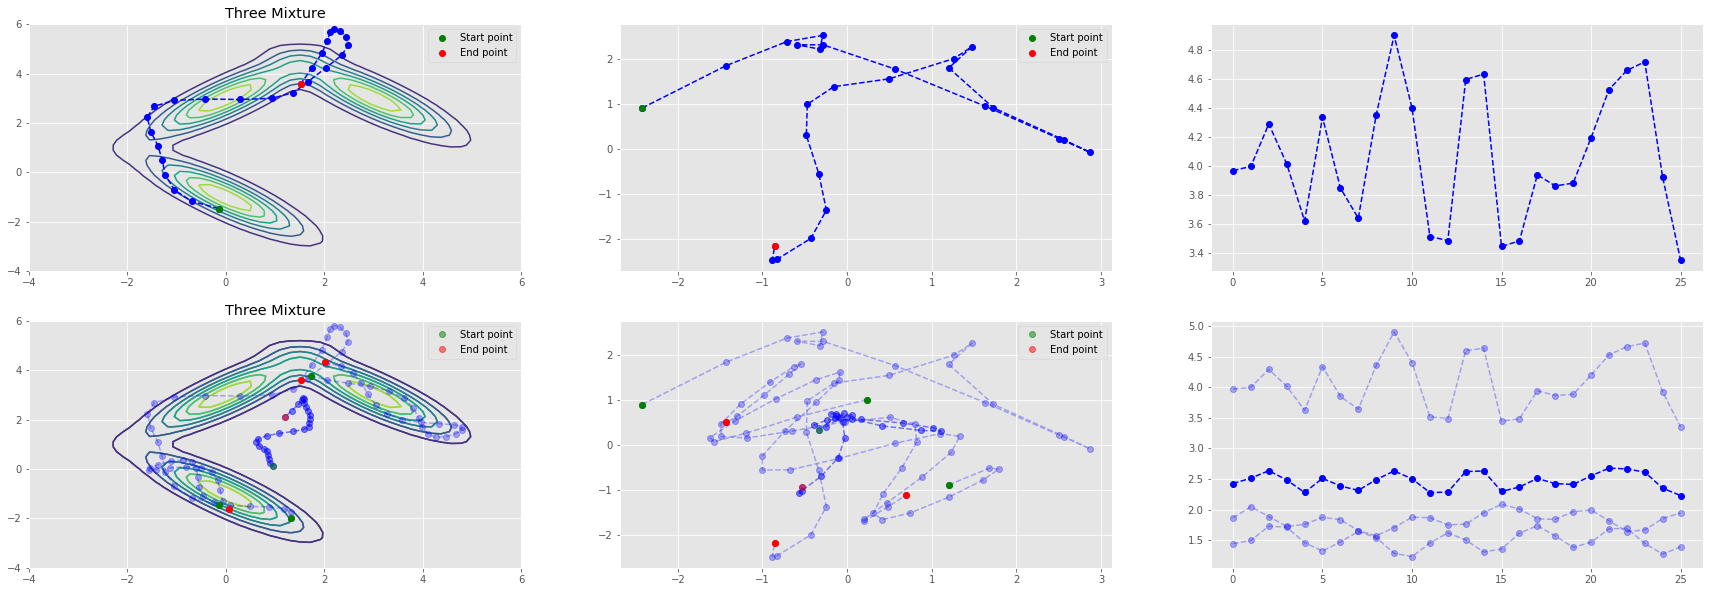

In [28]:
mu = torch.tensor([0,-1,0,3,3,3], dtype=torch.float).reshape(3,2)
L = torch.cholesky(torch.tensor([[1., 0.85], [0.85, 1.]]))
L_ = torch.cholesky(torch.tensor([[1., -0.85], [-0.85, 1.]]))
L_vec = torch.stack([L_, L, L_])

target = ThreeMixture(mu, L_vec)
proposal = HMCGaussKinetic(0.25, target, 25, diag=True, verbose=(3,2))
rw_mix_sampler = MHSampler(proposal, target)

init = torch.tensor([0.,1.]).repeat((3,1))
init += 1.5 * torch.randn_like(init)
rw_mix_sampler.sample_chain(init, 100)
proposal.plot2d_trace_trajectory(0, [(-4,6), (-4,6)], reinit=False)

<a id='hmcmagicstepsize'></a>
### HMC: Magic Step Size

Consider one sample sampling by HMC from pickle rick distriubtion with step-sizes $$eps = 0.1, 0.2, 0.3, 0.4, 0.44, 0.449$$
Use '.plot2d_trace_trajectory' to plot results.

100%|██████████| 1/1 [00:00<00:00, 90.78it/s]


AR: 1.00, ESS: 2.00


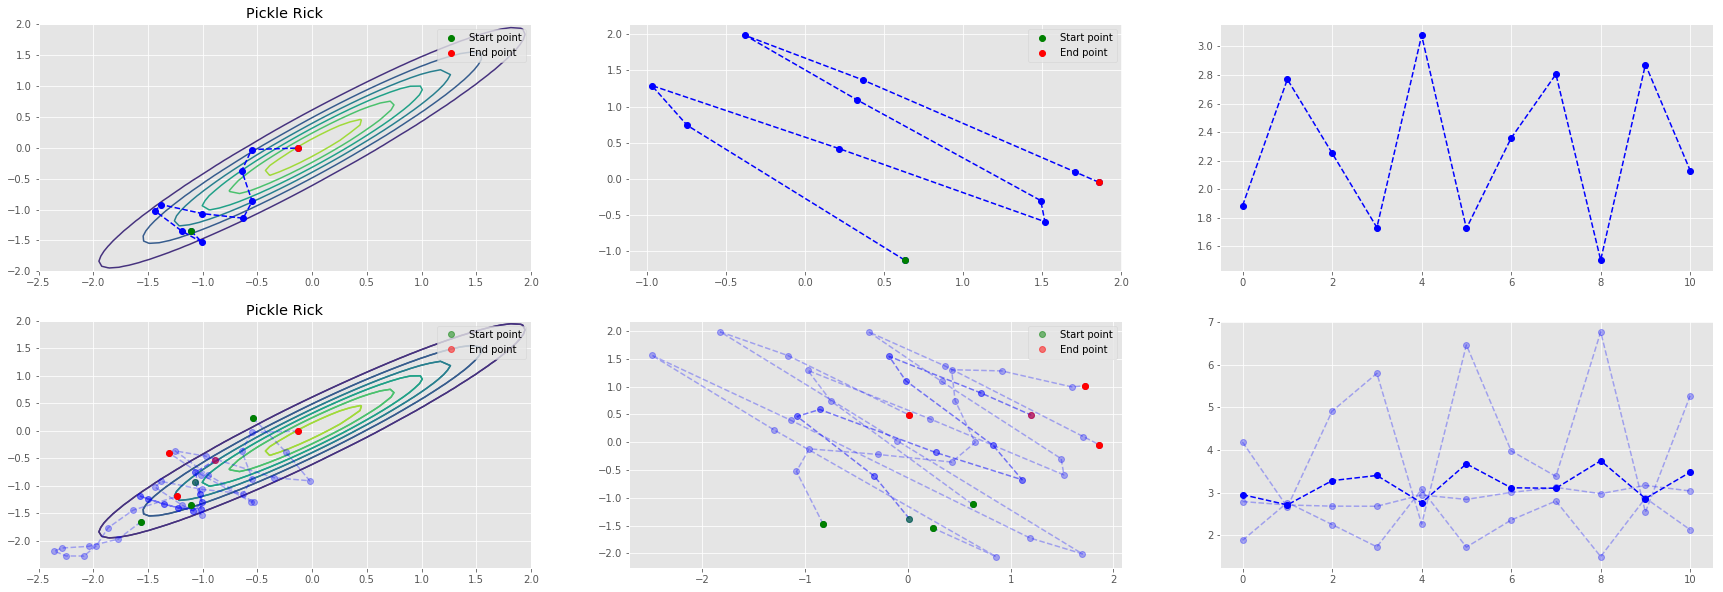

In [29]:
# your code here

100%|██████████| 1/1 [00:00<00:00, 76.90it/s]
/home/evgenii.egorov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less_equal


AR: 0.00, ESS: 2.00


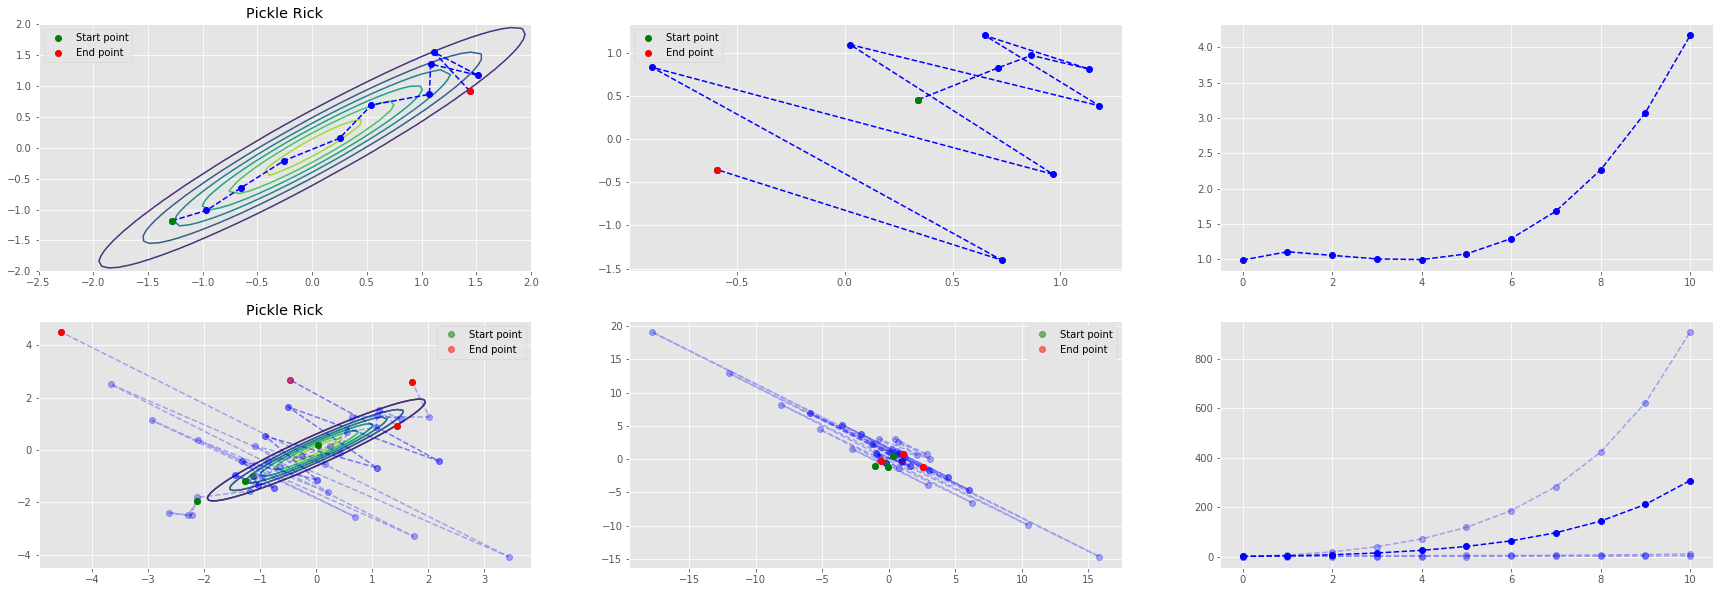

In [30]:
# your code here